# Pneumothorax Segmentation on X-ray Images

Dr. Yu Sun (yu.sun@sydney.edu.au)

14/11/2021


# Introduction
This document is a work solution to the Kaggle competition on pneumothorax segmentation from X-ray images. 

## Pneumothorax
Pneumothorax is a medical condition where the lung is collapsed. Severe pneumothorax can lead to emergency. A normal lung will fill the thorax leaving no extra space in between. Pneumothorax is visually identified on X-ray images by looking for spaces between the lung boundary and the thorax. 

## Data
X-ray images are provided from the competition in DICOM (`.dcm`) format, which can be manipulated using the `pydicom` or `SimpleITK` library. The competition released a dataset containing a total of 12089 training images and 3205 test images. The training image comes with a unique identifier (`ImageID`) and the ground truth annotations as binary mask, with the pixel coordinates stored in the run-length encoding (`EncodedPixels`). For example, '1 3 10 5' contains two runs: pixels 1,2,3 and pixels 14,15,16,17,18. Images without pneumothorax are labelled with `-1`. An example of such correspondence is shown below.

```
ImageId,                 EncodedPixels
0004d4463b50_01,        -1
0004d4463b50_02,         1 10
0004d4463b50_03,         1 30 3 5
...
```

At the end, the contours will be converted to a mask, with the same size as the corresponding X-ray images.

## Task
The goal is to train a segmentation model that takes a X-ray image and output the binary mask for pneumothorax. Mean Dice will be used to evaluate the performance on the held out test data. 

More details can be found on the [competition page](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation).

# Strategy
From the task we can tell
* It's a segmentation problem, so a network like FCN (fully convolutional network) or U-net will be used.
* The lung contains lots of textures, which can be important for the model. Transfer learning can be used to make good use of the pre-trained feature extractors.
* Theoretically the pneumothorax area will be darker, as more air is present in the X-ray path. This might be the general pattern of pneumothorax a model can ultilise.
* The pneumothorax will also lie between the border between the lung and the thorax. A good model will be able to localise these borders and pick up the gap in between.
* Some details to find out
    * How big is generally is the pneumothorax area? The smaller, the harder the problem, and more reliant on a good model design.
    * Are the X-ray images uniformed sized? If so, all images can be resized to a uniform size without shape distortion. This will make the input more homogeneous.
    * Is there one contour for each image? If there are multiple, would be good to know the difference. 
    
We are going to firstly go through one example, then find out the answers of these questions.

# Going through one case

Data have been downloaded from the Kaggle page and placed in `data`. First, let's start with one image.

## Utility functions
A selection of functions are included in the `utils.py` to perform common tasks, such as joining paths and resizing images.

In [ ]:
from utils import *

## Get the file paths

In [ ]:
# Import the required modules to read and plot DICOM
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('bmh')

In [ ]:
# Define the data folder
dataDir = 'data'
trImgDir = path(dataDir, 'dicom-images-train') # Training img folder
tsImgDir = path(dataDir, 'dicom-images-test')  # Testing img folder
infoPath = path(dataDir, 'train-rle.csv') # The ground truth file

In [ ]:
# Get the paths of all training DICOM files

# os.walk() interates the folder
#  returns (folder, sub-folders, files)
walk = os.walk(trImgDir) 

# Keep the entries where there's one file and it ends with '.dcm'
fl = [i for i in list(walk) if len(i[2])==1 and i[2][0].endswith('.dcm')]

In [ ]:
# Check the number of DICOM files
len(fl)

12089

This matches with the number in the training folder.

## Read and display X-ray

In [ ]:
# Read a random DICOM file
entry = fl[50]
eachDir, eachFile = entry[0], entry[2][0]
dcm = pydicom.read_file(path(eachDir, eachFile))

In [ ]:
# Inspect any demographics info
# Sometimes the demographics can be used to stratify the model (e.g. by gender or age group).
print(dcm)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10046.1517875221.743999
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10046.1517875221.743999
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Gender `(0010, 0040) Patient's Sex` and age `(0010, 1010) Patient's Age` is there. This may be potentially useful in future model sratification. For now, let's leave it there.

In [ ]:
# Extract the pixel array
# i.e. the part that encodes the image
img = dcm.pixel_array

In [ ]:
# Check the shape
img.shape

(1024, 1024)

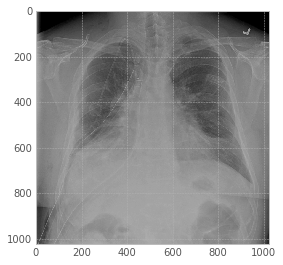

In [ ]:
# Visualise
plt.imshow(img, cmap='gray')
plt.show()

Next let's get the ground truth contours.

## Load and visualise contours

In [ ]:
# Import pandas for CSV manipulation
import pandas as pd

In [ ]:
# Read the ground truth CSV
info = pd.read_csv(infoPath)

In [ ]:
# Check the size
info.shape

(12954, 8)

In [ ]:
# Check the first few rows
info.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [ ]:
# Get the corresponding row
eachId = os.path.splitext(eachFile)[0]
eachInfo = info[info.ImageId==eachId]
eachInfo

,ImageId,EncodedPixels
9871,1.2.276.0.7230010.3.1.4.8323329.10046.15178752...,268480 3 1020 4 1018 5 1018 6 1017 6 1017 6 10...


In [ ]:
# Save the contour pixels
eachContPix = eachInfo[' EncodedPixels'].values[0]
print(eachContPix)

268480 3 1020 4 1018 5 1018 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 6 1017 7 1016 7 1016 7 1016 8 1015 8 1015 9 1014 9 1014 9 1014 10 1013 10 1013 10 1013 11 1012 11 1012 11 1012 12 1011 12 1011 13 1010 13 1010 14 1009 14 1010 14 1009 14 1009 15 1008 16 1008 15 1008 16 1007 16 1007 17 1005 18 1005 19 1004 19 1005 18 1005 19 1004 19 1004 20 1004 19 1004 20 1003 20 1003 21 1003 20 1003 21 1002 22 1001 22 1001 23 1000 23 1000 24 999 24 1000 24 999 24 999 25 998 26 997 26 997 27 997 26 997 27 996 27 997 26 997 27 997 26 997 27 997 27 996 28 995 28 996 28 995 29 994 30 993 31 993 30 993 31 992 32 992 32 991 33 991 32 991 33 991 32 991 31 992 31 993 31 992 32 992 32 991 33 991 33 990 35 989 35 988 36 988 36 988 36 987 37 987 37 986 38 986 38 985 39 985 39 984 40 984 40 984 40 983 41 983 41 983 41 983 41 982 42 982 42 982 43 981 43 981 43 980 44 980 44 980 45 979 45 979 45 978 46 978 46 978 47 977 47 977 48 976 48 976 49 975 49 975 49 975 49 

Let's visualise these pixels using the provided functions from Kaggle.

In [ ]:
# Import the functions
from mask_functions import *

In [ ]:
# Convert to mask
# The transpose is used so that it's consistent with
#  the row / col in pydicom
eachCont = rle2mask(eachContPix, *img.shape).T

In [ ]:
# Check the unique values
# Make sure it's binary
np.unique(eachCont)

array([  0., 255.])

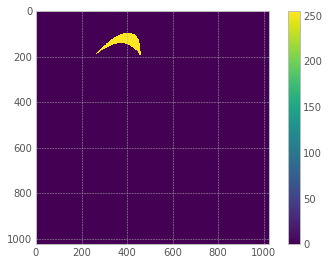

In [ ]:
# Visualise the mask
plt.imshow(eachCont)
plt.colorbar()
plt.show()

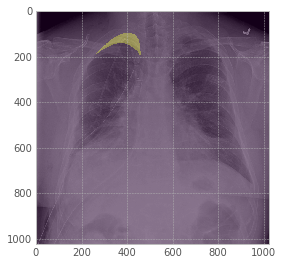

In [ ]:
# Overlay with the X-ray
plt.imshow(img, cmap='gray')
plt.imshow(eachCont, alpha=0.3)
# plt.colorbar()
# plt.title(eachId)
plt.show()

In [ ]:
# Make it as a function for latter use
def plotImg(imageid, alpha=0.3):
    'Plot the X-ray image overlaid with the contours'
    
    # Get DICOM data
    entry = [i for i in fl if os.path.splitext(i[2][0])[0]==imageid]
    eachDir, _ignore, eachFile = entry[0]
    dcm = pydicom.read_file(path(eachDir, eachFile[0]))
    img = dcm.pixel_array
    
    # Get contours
    eachInfo = info[info.ImageId==imageid]
    eachContPix = eachInfo[' EncodedPixels'].values
    
    # Plot
    plt.imshow(img, cmap='gray')
    for c in eachContPix:
        if c!='-1':
            eachCont = rle2mask(c, *img.shape).T
            plt.imshow(eachCont, alpha=alpha)
    
    # plt.colorbar()
    # plt.title(imageid)
    plt.show()

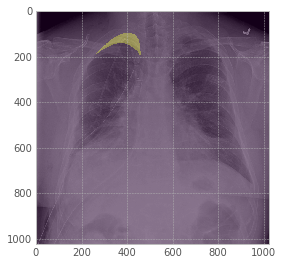

In [ ]:
# Test the plotImg()
plotImg(eachId)

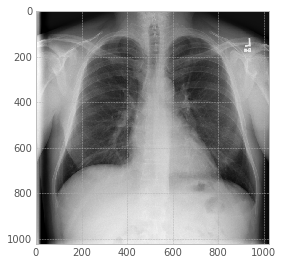

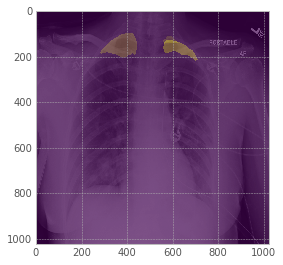

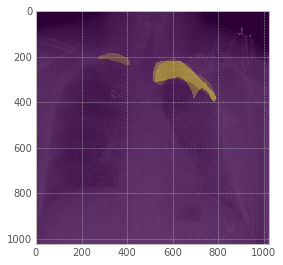

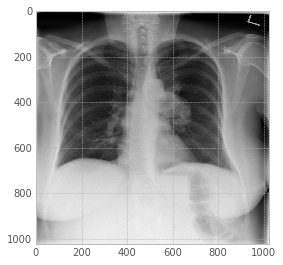

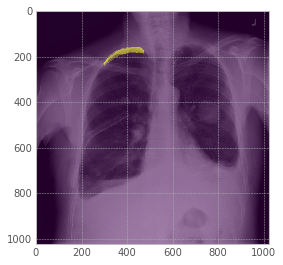

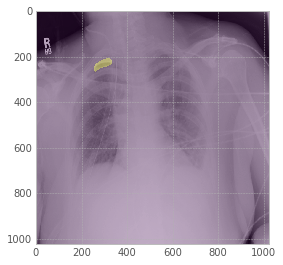

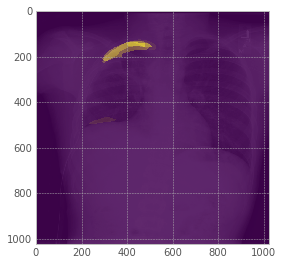

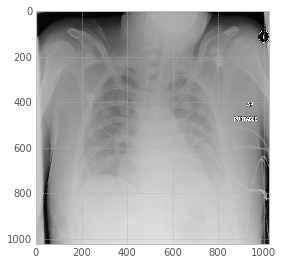

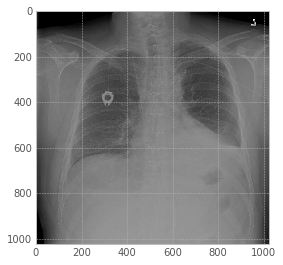

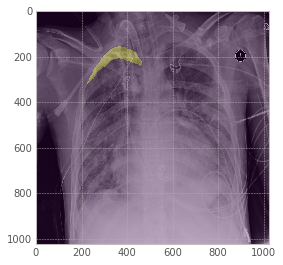

In [ ]:
# Plot on more images
for i in np.random.choice(info['ImageId'], 10):
    plotImg(i)

This section explores the steps to access and visualise the data. Next, we will go through all data.

# EDA (Explorative Data Analysis)

## What is the percentage of the contours

In [ ]:
# Define a function to calculate the sum of pixels
def rle2sum(rle):
    'Converts the rle encoding to the sum of pixels'
    if rle=='-1':
        return 0
    else:
        rleArr = np.array([int(i) for i in rle.split()])
        pixelSum = rleArr[1::2].sum()
        return pixelSum

In [ ]:
# Apply
info['PixelSum'] = info[' EncodedPixels'].apply(rle2sum) # Sum of contour pixels
info['PixelPct'] = info['PixelSum'] / (1024 * 1024)      # Percentage of pixels
info['HasPT'] = info['PixelSum']!=0        # Has pneumothorax

In [ ]:
# How many cases are pneumothorax positive
info['HasPT'].sum()

3576

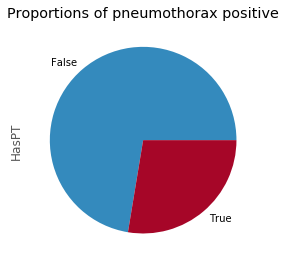

In [ ]:
# Proportions of pneumothorax positive
info['HasPT'].value_counts().plot.pie()
plt.title('Proportions of pneumothorax positive')
plt.show()

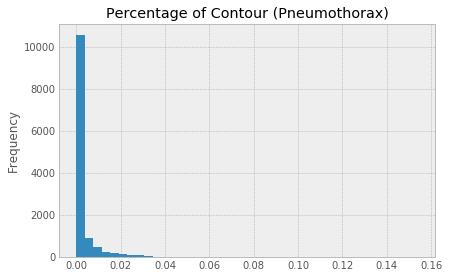

In [ ]:
# Distribution of the contour percentage
info['PixelPct'].plot.hist(bins=40)
plt.title('Percentage of Contour (Pneumothorax)')
plt.show()

It shows that the majority of the pneumothorax contours is relatively small for the X-ray images.

## More information from the DICOM

In [ ]:
# Get more info from the DICOM
#  including image shape, gender and age
imgShape = [] 
gender = []   
age = []      

for imageid in tqdm(info.ImageId):
    # Ge the corresponding DICOM path
    entry = [i for i in fl if os.path.splitext(i[2][0])[0]==imageid]
    assert len(entry) == 1
    eachDir, _ignore, eachFile = entry[0]
    eachDcm = pydicom.read_file(path(eachDir, eachFile[0]))
    
    # Retrieve and save the info
    imgShape.append(eachDcm.pixel_array.shape)
    gender.append(eachDcm[('0010', '0040')].value)
    age.append(eachDcm[('0010', '1010')].value)

100%|███████████████████████████████████████████████████| 12954/12954 [08:36<00:00, 25.10it/s]


In [ ]:
# Append to the info
info['ImgShape'] = imgShape
info['Gender'] = gender
info['Age'] = age
info['Age'] = info['Age'].astype(int)

In [ ]:
info.head()

,ImageId,EncodedPixels,PixelSum,PixelPct,HasPT,ImgShape,Gender,Age
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,0.000000,False,"(1024, 1024)",M,62
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,30859,0.029429,True,"(1024, 1024)",M,34
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,0.000000,False,"(1024, 1024)",F,52
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,5185,0.004945,True,"(1024, 1024)",F,30
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,48239,0.046004,True,"(1024, 1024)",F,57


In [ ]:
# Is the image shape the same for all DICOM
info['ImgShape'].value_counts()

(1024, 1024)    12954
Name: ImgShape, dtype: int64

This shows that all training image has the same dimension: 1024 x 1024.

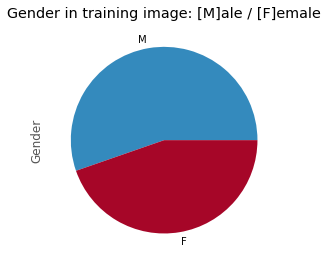

In [ ]:
# What is the percentage of gender
info['Gender'].value_counts().plot.pie()
plt.title('Gender in training image: [M]ale / [F]emale')
plt.show()

In [ ]:
# Statistics on age
info['Age'].describe()

count    12954.000000
mean        46.818898
std         17.072036
min          1.000000
25%         34.000000
50%         49.000000
75%         59.000000
max        413.000000
Name: Age, dtype: float64

It shows that some values in DICOM header are not credible. Age maximum could not be 413. Asumming the other ages are valid, we can check any relationship between age and the pneumothorax volume (pixel percentage).

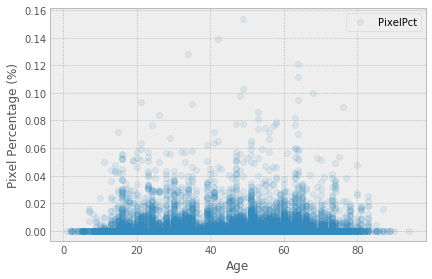

In [ ]:
# Any relationship between age and the pneumothorax volume
info[info.Age<100].plot(x='Age', y='PixelPct', style='o', alpha=0.1)
plt.ylabel('Pixel Percentage (%)')
plt.show()

No apparent relationship is shown between age and pneumothorax volume (pixel percentage).

## Uninque ImageId

The last question is to check why the `info` has more rows than the training images. This implies that some images have more than one contour.

In [ ]:
info['ImageId'].value_counts()

1.2.276.0.7230010.3.1.4.8323329.1851.1517875169.919023     10
1.2.276.0.7230010.3.1.4.8323329.13026.1517875243.170116     8
1.2.276.0.7230010.3.1.4.8323329.5073.1517875186.287848      8
1.2.276.0.7230010.3.1.4.8323329.497.1517875163.185132       7
1.2.276.0.7230010.3.1.4.8323329.2166.1517875171.437026      6
                                                           ..
1.2.276.0.7230010.3.1.4.8323329.10062.1517875221.809128     1
1.2.276.0.7230010.3.1.4.8323329.13437.1517875245.324187     1
1.2.276.0.7230010.3.1.4.8323329.11903.1517875236.369741     1
1.2.276.0.7230010.3.1.4.8323329.13344.1517875244.736984     1
1.2.276.0.7230010.3.1.4.8323329.31901.1517875157.403954     1
Name: ImageId, Length: 12047, dtype: int64

We can see there are indeed images that have more than one contour, perhaps annotated by different observers. We can further check the distribution of annotation duplicates.

In [ ]:
info['ImageId'].value_counts().value_counts()

1     11423
2       447
3       112
4        40
5        18
6         3
8         2
7         1
10        1
Name: ImageId, dtype: int64

It shows that quite a few have between 2 and 5 annotation duplicates.

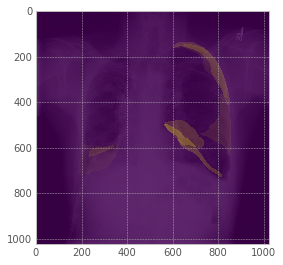

In [ ]:
# Plot an image overlay with different contours
# Take the one with 8 annotations
imageid = '1.2.276.0.7230010.3.1.4.8323329.13026.1517875243.170116'
plotImg(imageid, alpha=0.2)

We can see the inter-observer variability of the ground truth contour is quite significant.

# Data preparation

Move all DICOM files to one folder.

In [ ]:
import os
import shutil
import skimage.io

In [ ]:
# Save the DICOM to one folder 
saveDir = path(dataDir, 'trDcm')
os.makedirs(saveDir)

# Copy the files over
for (eachDir, _ignore, eachFile) in tqdm(fl):
    shutil.copy(
        src=path(eachDir, eachFile[0]),
        dst=path(saveDir, eachFile[0])
    )

100%|███████████████████████████████████████| 12089/12089 [01:44<00:00, 115.42it/s]


Convert DICOM to image files.

In [ ]:
imgDir = path(dataDir, 'imgs')
os.makedirs(imgDir)

In [ ]:
# Convert data to np objects
for imageid, label in tqdm(info.iloc[:, :2].values):
    # Get the image and contour
    dcm_path = path(saveDir, imageid+'.dcm')
    dcm = pydicom.read_file(dcm_path)
    img = dcm.pixel_array.astype(np.uint8)
    if label=='-1':
        cont = np.zeros_like(img, dtype=np.uint8)
    else:
        cont = rle2mask(label, *img.shape).T.astype(np.uint8)
    # Save as images
    # Each imageid will have one contour
    skimage.io.imsave(path(imgDir, imageid+'-i.jpg'), img, 
                    check_contrast=False)
    skimage.io.imsave(path(imgDir, imageid+'-c.jpg'), cont,
                    check_contrast=False)

100%|████████████████████████████████████████| 12954/12954 [08:28<00:00, 25.49it/s]


The data is uploaded to a server with GPU for model development.